# Datos de tráfico del Gobierno de UK, "Unplanned Events"


Se trabajará con los “Unplanned Events” que se proporcionan en un formato XML. Se puede descarga de la URL:
http://hatrafficinfo.dft.gov.uk/feeds/datex/England/UnplannedEvent/content.xml

Concretamente, contiene un conjunto de situaciones (“situation”) y dentro de la descripción
de las situaciones, nos interesa el impacto (“impact”).

Procedimiento:
- importar librerías 
- descarga del xml "Unplanned Events" de la URL
- lectura y parseado del fichero
- investigar el impacto de los eventos no planificados en el resto de variables
- análisis descriptivo de al menos tres de las variables

In [25]:
from lxml import objectify
import pandas as pd

In [26]:
# Descarga del fichero UnplannedEvents.xml y parseado
parsed = objectify.parse('http://hatrafficinfo.dft.gov.uk/feeds/datex/England/UnplannedEvent/content.xml')
root = parsed.getroot()
print root.tag
print root.attrib
print root.countchildren()

{http://datex2.eu/schema/1_0/1_0}d2LogicalModel
{'modelBaseVersion': '1.0'}
2


In [27]:
# Contrucción del dataframe con variables seleccionadas y obtención de la información
# Esta construcción no funcinaría si alguno de los campos faltara para alguna situation
df_ue = pd.DataFrame(columns=["probabilityOfOccurrence","impactOnTraffic", "capacityRemaining", "numberOfLanesRestricted", "numberOfOperationalLanes", "originalNumberOfLanes", "delayTimeValue", "situationRecordVersion"])

for sit in root.payloadPublication.situation:
    id = sit.attrib['id']
    probabilityOfOccurrence=sit.situationRecord.probabilityOfOccurrence.text
    impactOnTraffic = sit.situationRecord.impact.impactOnTraffic.text    
    capacityRemaining = float(sit.situationRecord.impact.impactDetails.capacityRemaining.text)
    numberOfLanesRestricted = int(sit.situationRecord.impact.impactDetails.numberOfLanesRestricted.text)
    numberOfOperationalLanes = int(sit.situationRecord.impact.impactDetails.numberOfOperationalLanes.text)
    originalNumberOfLanes = int(sit.situationRecord.impact.impactDetails.originalNumberOfLanes.text)    
    delayTimeValue = float(sit.situationRecord.impact.delays.delayTimeValue.text)
    situationRecordVersion=int(sit.situationRecord.situationRecordVersion.text)
    
    df_ue.loc[id] = [probabilityOfOccurrence, impactOnTraffic, capacityRemaining, numberOfLanesRestricted, numberOfOperationalLanes,  originalNumberOfLanes, delayTimeValue, situationRecordVersion]

df_ue

,probabilityOfOccurrence,impactOnTraffic,capacityRemaining,numberOfLanesRestricted,numberOfOperationalLanes,originalNumberOfLanes,delayTimeValue,situationRecordVersion
GUID732336731,certain,heavy,75.0,1.0,3.0,4.0,600.0,44.0
GUID732889125,certain,impossible,0.0,2.0,0.0,2.0,900.0,15.0
GUID732957845,certain,impossible,0.0,1.0,0.0,1.0,600.0,6.0
GUID733038589,certain,impossible,0.0,1.0,0.0,1.0,0.0,1.0
GUID733038591,certain,impossible,0.0,1.0,0.0,1.0,0.0,1.0
GUID733043648,certain,freeFlow,33.0,2.0,1.0,3.0,0.0,2.0


In [22]:
df_ue.shape

(6, 8)

Asumimos que la variable dependiente es 'delayTimeValue', al querer analizar cómo determinadas variables que describen un evento no planificado tienen un impacto en esta varaible.

La variable 'proboccurrence' no aportaría ningún valor a un posible análisis ya que su valor es constante. Siempre toma el valor='certain'. Se eliminará del análisis.

Hay cuatro variables que podrían resumirse en una. La variable 'numberOfLanesRestricted' es un combinación lineal de 'originalNumberofLanes' y 'numberOfOperationalLanes'. 

La variable 'capacityRemaining' es una transformación de la variable 'numberOfOperationalLanes', por lo que, de nuevo, es una combinación lineal de 'originalNumberofLanes' y 'numberOfOperationalLanes'.

Por lo tanto, se eliminarán las siguientes variables 'numberOfLanesRestricted'  'numberOfOperationalLanes', y 'originalNumberofLanes'; se mantendrá  'capacityRemaining', que recoge toda la información necesaria. El principio de parsimonia o cuchilla de afeitar de Occam, indica que las descripciones deben mantenerse lo más simples posibles hasta el momento que se demuestre que resultan inadecuadas. Adicionalmente, la introducción de información redudante puede llevar a la elección de una forma funcional incorrecta en la modelización (aunque en este caso no se va a proceder a realizar ninguna modelización con seis observaciones).

El escaso número de observaciones, un total de seis, no permite realizar ningún  análisis. No obstante, con el con el objeto de jugar con las opciones de pandas, se va aproceder a calcular correlaciones y a realizar un pairwise plot.

In [28]:
df_ue_f = df_ue[["impactOnTraffic", "capacityRemaining","delayTimeValue", "situationRecordVersion"]]

In [29]:
df_ue_f.corr(method='pearson')

,capacityRemaining,delayTimeValue,situationRecordVersion
capacityRemaining,1.000000,0.116920,0.819149
delayTimeValue,0.116920,1.000000,0.578049
situationRecordVersion,0.819149,0.578049,1.000000


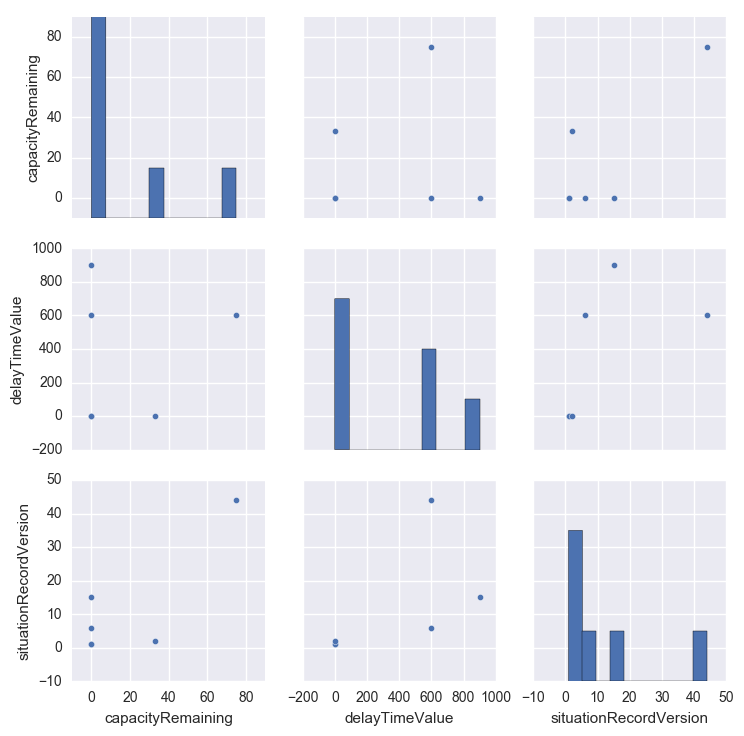

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_ue_f[["impactOnTraffic", "capacityRemaining","delayTimeValue", "situationRecordVersion"]])
plt.show()